In [1]:
# Load common utility functions (assumed to define custom operators, correlators, etc.)
include("common_functions.jl")

# Enable LaTeX-formatted labels for plots
using LaTeXStrings

In [2]:
# Define lists of system sizes, perturbation strengths, and lambda values
Nlist = [32, 64, 128, 256, 512]
pert_list = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.05, 0.06]
λlist = [0.94, 0.95, 0.96, 0.965, 0.97, 0.975, 0.98, 0.985, 0.99]  # Not used in this loop

# Initialize containers for metadata and loaded MPS states
N_super_list = []
pert_super_list = []
λ_super_list = []  # Unused here but defined for future expansion
state_super_list = []

# Loop over system sizes and perturbation strengths
for N in Nlist
    for pert in pert_list
        # Construct filename for the HDF5 file
        filename = "./data/saved_MPS/scaling_collapse_MPS/projected_Lzz_$(N)_$(pert).h5"
        
        # Open file, read the MPS state, and close
        f = h5open(filename, "r")
        state = read(f, "state", MPS)
        close(f)
        
        # Store state and associated metadata
        push!(state_super_list, state)
        push!(pert_super_list, pert)
        push!(N_super_list, N)
    end
end

In [3]:
"""
    annotatewithbox!(fig::Plots.Plot, text::Plots.PlotText, x::Real, y::Real, Δx::Real, Δy::Real = Δx; kwargs...)

Annotate a plot `fig` at coordinates `(x, y)` with `text`, and draw a rectangular white background box of dimensions `(Δx, Δy)` behind it for clarity.

Arguments:
- `fig`: the plot object to annotate.
- `text`: the LaTeX or text string to annotate.
- `x, y`: coordinates where the annotation is placed.
- `Δx, Δy`: dimensions of the background box. If `Δy` is not provided, it defaults to `Δx`.
- `kwargs...`: additional keyword arguments passed to `plot!` for box styling (e.g., `alpha`, `linewidth`, `color`, etc.).

Returns:
- The modified `fig` with the annotation and background box.
"""
function annotatewithbox!(
    fig::Plots.Plot,
    text::Plots.PlotText,
    x::Real, y::Real, Δx::Real, Δy::Real = Δx;
    kwargs...
)
    # Create a rectangle shape
    box = Plots.Shape(:rect)
    
    # Scale and position the rectangle
    Plots.scale!(box, Δx, Δy)
    Plots.translate!(box, x, y)
    
    # Plot the rectangle behind the text
    Plots.plot!(fig, box; c=:white, linestroke=:black, label=false, kwargs...)
    
    # Annotate with the given text
    Plots.annotate!(fig, x, y, text)
    
    return fig
end

annotatewithbox!

In [4]:
# Use the loaded MPS states as the strong state list for further analysis
strong_state_list = state_super_list
;

In [5]:
# Lists to store computed string correlators for various system sizes and perturbations
string_super_list = []
trivial1_super_list = []
trivial2_super_list = []
nm_super_list = []

# Loop over all states corresponding to different N and perturbations
for i in 1:length(N_super_list)
    N = N_super_list[i]

    # Choose two odd sites approximately at 1/4 and 3/4 of the system length
    n = N ÷ 4
    n = isodd(n) ? n : n + 1  # ensure n is odd
    m = (3 * N) ÷ 4
    m = isodd(m) ? m : m + 1  # ensure m is odd

    # Get projected state
    ppstate = strong_state_list[i]

    # Compute 2-copy and 1-copy string correlators
    tr2 = strong_nontrivial_2copy_correlator(ppstate, n, m, true)
    tr1 = strong_nontrivial_1copy_correlator(ppstate, n, m)

    # Save results
    push!(trivial1_super_list, tr1)
    push!(trivial2_super_list, tr2)
    push!(nm_super_list, [n, m])
end

In [6]:
# Initialize lists to store trimmed data
pert_trim = []
λ_trim = []
N_trim = []
string1_trim = []
string2_trim = []

# Copy selected data for plotting or analysis
for i in 1:length(N_super_list)
    push!(N_trim, N_super_list[i])
    push!(pert_trim, pert_super_list[i])
    push!(string1_trim, trivial1_super_list[i])
    push!(string2_trim, trivial2_super_list[i])
end

# Reshape the string correlator arrays for easier plotting/scaling
# Each row corresponds to a different perturbation, each column to a different N
stringarr1 = reshape(abs.(trivial1_super_list), (length(pert_list), length(Nlist)))
stringarr2 = reshape(abs.(trivial2_super_list), (length(pert_list), length(Nlist)))

9×5 Matrix{Float64}:
 0.997368  0.99469   0.984266   0.911234     0.461286
 0.993452  0.984498  0.940425   0.663078     0.107883
 0.987248  0.965515  0.850166   0.378076     0.0198397
 0.978384  0.935303  0.71826    0.185771     0.00365859
 0.966557  0.892668  0.568942   0.0847104    0.000781626
 0.951562  0.838123  0.427876   0.0374181    0.000196504
 0.933301  0.7738    0.309715   0.0165244    5.49356e-5
 0.887212  0.629167  0.151275   0.00350006   5.05008e-6
 0.829832  0.485272  0.0707839  0.000876572  5.01463e-7

In [7]:
default(
    xformatter = :latex,        # Use LaTeX formatting for x-axis labels
    yformatter = :latex,        # Use LaTeX formatting for y-axis labels
    left_margin = 1Plots.mm,    # Set left margin to 1 mm
    legend = :right,            # Place legend on the right
    framestyle = :box,          # Box around the plot
    size = 1.6 .* (350, 250),   # Set plot size (scaled 1.6× from base)
    xminorticks = 3,            # Number of minor ticks between major ticks on x-axis
    yminorticks = 3,            # Number of minor ticks between major ticks on y-axis
    xticks = 8,                 # Number of x-axis ticks (or spacing, depending on context)
    yticks = 8,                 # Number of y-axis ticks
    xtickfontsize = 18,         # Font size for x-axis tick labels
    ytickfontsize = 18,         # Font size for y-axis tick labels
    xguidefontsize = 18,        # Font size for x-axis label
    yguidefontsize = 18,        # Font size for y-axis label
    legendfontsize = 10         # Font size for legend
)

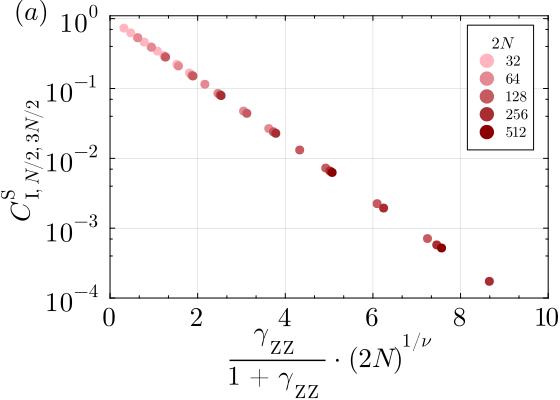

In [8]:
ν = 1.0

# Axis labels and plot title
ylbl = L"C_{\textrm{I}, N/2, 3N/2}^{\textrm{S}}"
xlbl = L"\frac{ \gamma_{\textrm{ZZ}}}{1 + \gamma_{\textrm{ZZ}}} \cdot (2N)^{1/\nu}"
ttl = L"\nu = $(ν)"
siz = 18

# Colorbar tick formatting (optional, currently unused)
colorbar_ticks = (minimum(N_trim):10:maximum(N_trim), string.(round.(Int, (minimum(N_trim):10:maximum(N_trim)) .* 100), "%"))

# Base plot
p = plot(
    xlabel = xlbl,
    ylabel = ylbl,
    zcolor = N_trim,
    ylim = (1e-4, 1.1),
    xlim = (0, 10),
    yticks = [1e-4, 1e-3, 1e-2, 1e-1, 1e0],
    xticks = 2 .* (0:7),
    yaxis = :log,
    legend = :topright,
    right_margin = -3Plots.mm,
    bottom_margin = 3Plots.mm,
    left_margin = 1.1Plots.mm,
    top_margin = 2Plots.mm,
    xtickfontsize = siz,
    ytickfontsize = siz,
    xguidefontsize = siz,
    yguidefontsize = siz,
    colorbar_title = L"N",
    legend_title = L"2N",
    grid = true
)

# Plot scatter points for each system size
for i in 1:length(Nlist)
    scaled_x = Nlist[i]^(1/ν) .* pert_list ./ (1 .+ pert_list)
    scatter!(p, scaled_x, stringarr1[:, i],
        label = "\$"*string(Nlist[i])*"\$",
        c = RGB(palette(:reds, length(Nlist))[i]),
        markerstrokewidth = 0,
        markersize = 5
    )
end

# Annotate plot
annotate!(-1.75, 1.2, text(L"(a)", 18), :black)

# Display or save
savefig(p, "./images/scaling_collapse_cs1_lzz.pdf")
display(p)

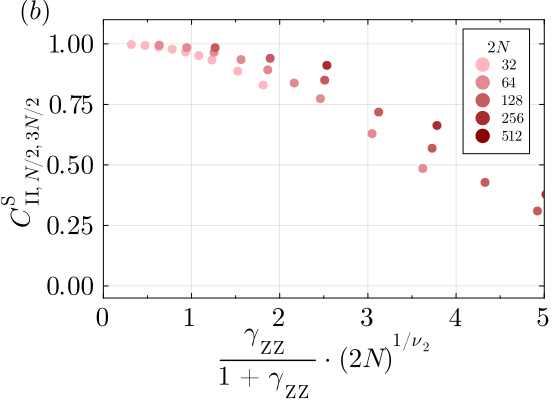

In [9]:
ν = 1.0  # Scaling exponent

# Axis labels
ylbl = L"C_{\textrm{II}, N/2, 3N/2}^{\textrm{S}}"
xlbl = L"\frac{ \gamma_{\textrm{ZZ}} }{ 1 + \gamma_{\textrm{ZZ}} } \cdot (2N)^{1/\nu_2}"

siz = 18

p = plot(
    xlabel = xlbl,
    ylabel = ylbl,
    zcolor = N_trim,
    label = "",
    yticks = [0, 0.25, 0.5, 0.75, 1.0],
    yminorticks = 1,
    ylim = (-0.05, 1.1),
    xlim = (0, 5),
    xticks = 0:1:5,
    xminorticks = 2,
    right_margin = -2Plots.mm,
    bottom_margin = 3Plots.mm,
    left_margin = 1.1Plots.mm,
    top_margin = 3Plots.mm,
    xtickfontsize = siz,
    ytickfontsize = siz,
    xguidefontsize = siz,
    yguidefontsize = siz,
    colorbar_title = L"N",
    legend_title = L"2N",
    grid = true,
    legend = :topright
)

# Plot points for each N
for i in 1:length(Nlist)
    scaled_x = Nlist[i]^(1/ν) .* pert_list ./ (1 .+ pert_list)
    scatter!(
        p, scaled_x, stringarr2[:, i],
        label = "\$"*string(Nlist[i])*"\$",
        c = RGB(palette(:reds, length(Nlist))[i]),
        markerstrokewidth = 0,
        markersize = 5
    )
end

# Annotate subplot label
annotate!(-0.75, 1.13, text(L"(b)", 18), :black)

# Display or save
# savefig(p, "./images/for_paper/scaling_collapse_cs2_lzz.pdf")
display(p)